# **Model interpretation**

## Notebook overview

---

This notebook provides a technical audit of the final attrition model:

- **Artifacts Loaded** – trained logistic‐regression estimator, optimal F1 threshold (≈ 0.79), and the fully transformed hold-out set.  
- **Global Explainability** – SHAP violin and bar plots identify dominant risk factors (travel frequency, overtime, short tenure) and protective signals (tenure stability, technical education).  
- **Local Explainability** – SHAP waterfall diagrams decompose three representative predictions (high-risk, borderline, low-risk) to validate case-level logic.  
- **Coefficient Cross-check** – Top linear coefficients align with SHAP ranking, supporting model consistency.  
- **Threshold Analysis** – Comparison of 0.5 vs 0.79 illustrates the precision-recall trade-off and its operational impact on false-alert volume.

The objective is to verify that model behaviour is interpretable, consistent, and aligned with practical retention considerations.

## 1. Load Final Model, Threshold, and Preprocessed Data

---

First, we load our trained logistic regression model and optimal classification threshold (`0.79`) from the previous modeling stage. This ensures consistency and reproducibility in our analysis.

We import the fully preprocessed dataset — engineered, scaled, and encoded — exactly as the model expects. This step sets the foundation for exploring and understanding exactly how the model makes predictions about employee attrition.

In [1]:
# === Load final model, transformed test set, and labels for SHAP analysis ===
import joblib
import pandas as pd
# === Load transformed feature names from exported JSON ===
import json
import matplotlib.pyplot as plt
import numpy as np
import joblib
import sys
sys.path.append('../src')
from feature_engineering import FeatureEngineer

# Load transformed feature names used during model evaluation
with open("../models/x_test_columns.json", "r") as f:
    transformed_feature_names = json.load(f)

# Confirm successful load
print(f"Loaded {len(transformed_feature_names)} transformed feature names.")

# Readability
import warnings
warnings.filterwarnings("ignore", message="X has feature names")

# Load trained logistic regression model
classifier = joblib.load("../models/final_model.joblib")

# Load transformed test features
X_transformed = pd.read_csv("../data/processed/x_test_transformed.csv")

# Load final test labels (binarize if necessary)
y = pd.read_csv("../data/processed/y_final_test.csv")

# Convert to binary (if still in Yes/No string format)
if y.dtypes[0] == 'object':
    y = (y == "Yes").astype(int)

# Load the fully fitted preprocessing pipeline (already fit on training data)
fitted_pipeline = joblib.load("../models/fitted_pipeline.pkl")

print("Fitted preprocessing pipeline loaded successfully.")

# Confirm shapes
print(f"Loaded model and data.")
print(f"X shape: {X_transformed.shape}, y shape: {y.shape}")

best_threshold = 0.79

Loaded 75 transformed feature names.
Fitted preprocessing pipeline loaded successfully.
Loaded model and data.
X shape: (294, 75), y shape: (294, 1)


C:\Users\justi\AppData\Local\Temp\ipykernel_12004\2630517262.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y.dtypes[0] == 'object':


## 2. Global Feature Importance (SHAP)

---

With the model loaded, we now delve deeper: **What exactly is influencing the model's predictions?**  
We use SHAP values—powerful tools to quantify exactly how each feature contributes to predicting employee attrition. Let's explore this from two complementary perspectives.

### SHAP Violin Plot: Feature Impact Distribution

This beeswarm-style plot visualizes the distribution of SHAP values for each feature across individual employees. Each dot represents a single employee's SHAP value, indicating the strength and direction of a feature's influence:

- **Positive SHAP values (right)** indicate factors increasing attrition risk.
- **Negative SHAP values (left)** indicate factors reducing attrition risk.
- The **color intensity** shows feature value magnitude (red = higher, blue = lower).

**Key insights:**

- **Short Tenure (≤3 years)** and frequent **Overtime** consistently increase attrition risk. Employees newer to the organization or experiencing high workloads show a clear trend towards higher attrition probability.
- High numbers of previously worked companies (**NumCompaniesWorked**) also strongly correlate with increased risk, likely indicating lower organizational attachment.
- Features related to employee satisfaction (e.g., **SatisfactionMean**) and professional stability (e.g., **TotalWorkingYears**, **YearsCompany_Satisfaction**) predominantly reduce attrition risk, highlighting their role as protective factors.
- **Age** shows a clear protective trend—older employees are less likely to leave, indicating increasing organizational commitment or fewer career changes with age.

Overall, this visualization demonstrates nuanced individual-level variations, highlighting the diversity of risk factors across the employee population.

In [2]:
# === SHAP Explanation Setup ===
import shap
import matplotlib.pyplot as plt
from shap import LinearExplainer, summary_plot

# Initialize SHAP explainer for linear model
explainer = LinearExplainer(
    classifier,
    X_transformed,
    feature_names=transformed_feature_names
)

# Compute SHAP values
shap_values = explainer(X_transformed)

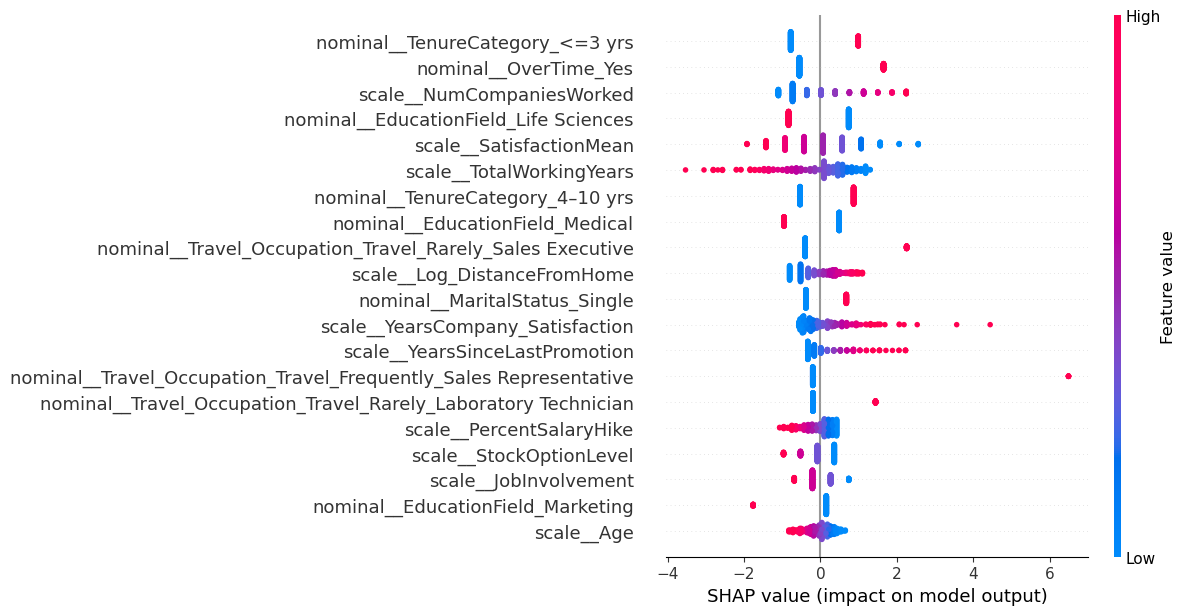

In [3]:
# === SHAP Summary Plot: Violin ===
summary_plot(
    shap_values,
    X_transformed,
    feature_names=transformed_feature_names,
    show=False
)

# Adjust layout
plt.gcf().set_size_inches(12.5, 7.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

### SHAP Bar Plot: Absolute Feature Importance

While the violin plot provides individual-level granularity, the bar plot aggregates SHAP values, capturing the average absolute impact of each feature on predictions—regardless of whether they increase or decrease risk:

**Key takeaways:**

- **TenureCategory (≤3 years)** emerges as the most impactful feature overall, strongly influencing attrition predictions. Shorter tenure consistently signals higher turnover likelihood, reflecting typical early-career volatility or misalignment.
- **Frequent Overtime** is also highly predictive of attrition risk, likely due to burnout, dissatisfaction, or work-life imbalance.
- Employees who've **worked at multiple companies** previously are perceived as higher attrition risks, possibly due to habitual job changes or lower commitment levels.
- Features capturing professional development and career stability (**TotalWorkingYears**, **YearsSinceLastPromotion**) significantly influence predictions, with longer tenure and recent promotions clearly indicating reduced attrition likelihood.
- Factors such as **StockOptionLevel** and **MonthlyIncome** have comparatively minor overall impact, suggesting compensation alone is less predictive of attrition compared to job satisfaction, tenure stability, or workload-related issues.

This aggregate view emphasizes consistent, broad patterns in attrition risks and highlights clear organizational focus areas for intervention, such as improving early-career experiences and managing employee workload effectively.

Together, these plots provide a comprehensive understanding of how and why the model makes its predictions, guiding targeted and strategic HR interventions.

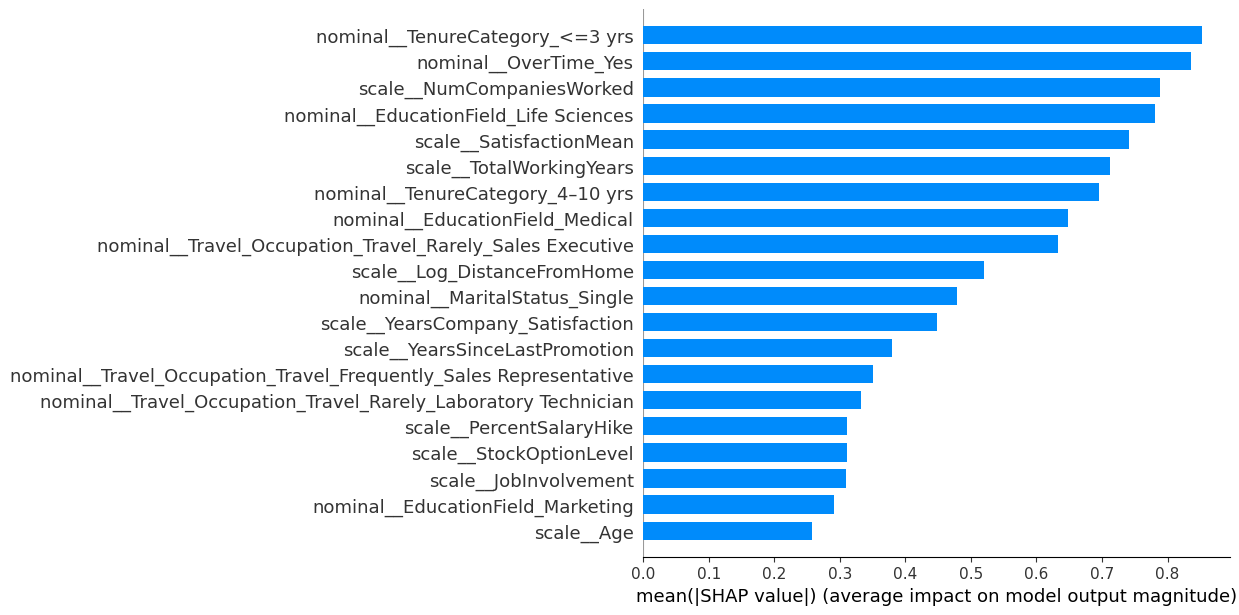

In [4]:
# === SHAP Summary Plot: Bar ===
summary_plot(
    shap_values,
    X_transformed,
    feature_names=transformed_feature_names,
    plot_type="bar",
    show=False
)

# Adjust layout
plt.gcf().set_size_inches(12.5, 7.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

## 3. Local Interpretation with SHAP

---

Shifting our focus from overall trends, we now explore **individual-level predictions**. Using SHAP waterfall plots, we gain clarity on exactly which features influenced the model's decisions in three illustrative cases:

In [7]:
# Cell 1: SHAP setup and index check
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1) Initialize JS support (optional, for interactive notebooks)
shap.initjs()

# 2) Compute the positive-class probabilities for each test row
#    (replace `predict_proba` call & array slicing if your pipeline is named differently)
probs = classifier.predict_proba(X_transformed)[:, 1]

# 3) Pick three illustrative cases:
#    - highest probability (most “at-risk”)
#    - lowest probability (most “safe”)
#    - median-ranked probability (borderline)
i_high       = np.argmax(probs)
i_low        = np.argmin(probs)
i_borderline = np.argsort(probs)[len(probs) // 2]

# 4) Confirm
print(f"indices →  high: {i_high},  borderline: {i_borderline},  low: {i_low}")


indices →  high: 92,  borderline: 37,  low: 131


In [8]:
# Cell 1: SHAP setup and index check
import shap
import matplotlib.pyplot as plt

# Initialize JS support (optional, for interactive notebooks)
shap.initjs()

# Confirm we have our indices
print(f"indices → high: {i_high}, borderline: {i_borderline}, low: {i_low}")


indices → high: 92, borderline: 37, low: 131


### High-Risk Case (Most Confident Prediction)

The following example illustrates how, despite having positive career aspects, intense work-related demands can decisively influence attrition predictions.

Why does the model strongly predict attrition for this employee?

- **Frequent travel in a Sales Representative role** emerges as the leading driver of attrition risk, suggesting potential burnout or dissatisfaction due to demanding travel requirements.
- **Overtime** contributes significantly, further exacerbating attrition likelihood.
- Interestingly, the employee's extensive **total working years** and relatively **high average satisfaction** act as protective factors, yet they aren't sufficient to outweigh the negative pressures from travel and overtime.


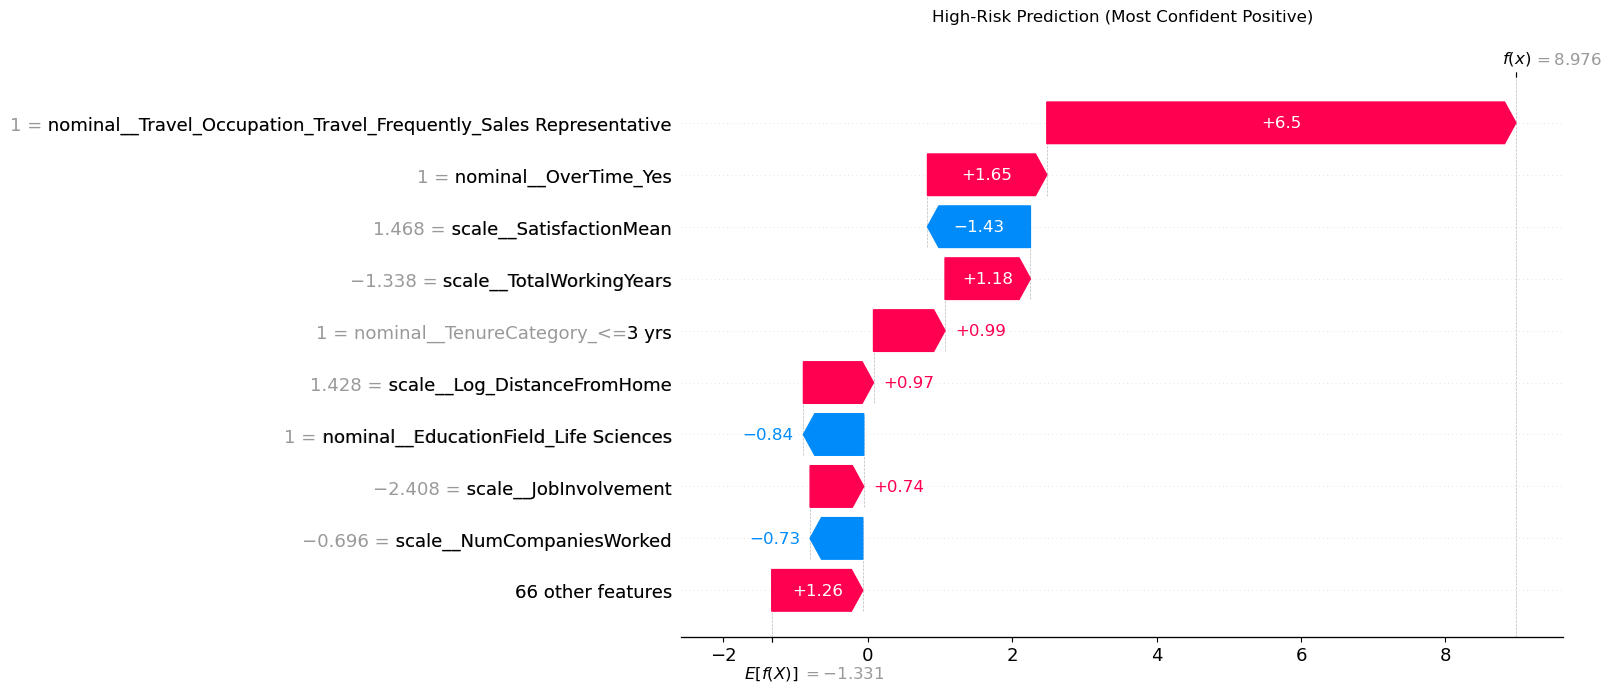

In [22]:
# Cell 2: High-Risk Prediction (Most Confident Positive)

import shap
import matplotlib.pyplot as plt

# 1) Draw the SHAP waterfall on the default figure (no internal show)
_ = shap.plots.waterfall(
    shap_values[i_high],
    max_display=10,
    show=False
)

# 2) Grab the current figure & axes that SHAP just created
fig = plt.gcf()
ax  = plt.gca()

# 3) Resize the figure for long labels
fig.set_size_inches(14, 7)

# 4) Shift margins so feature names aren’t squished
fig.subplots_adjust(left=0.32, right=0.95, top=0.9, bottom=0.1)

# 5) Add your title with padding
ax.set_title("High-Risk Prediction (Most Confident Positive)", pad=20)

# 6) Finally render
plt.show()


### Borderline Case (Near Threshold Prediction)

This case sits right at the decision boundary, making it an insightful scenario for understanding nuanced predictions:

- Again, **overtime** notably pushes the employee toward attrition.
- The model encounters mixed signals: moderate levels of **satisfaction** and mid-range tenure (**4–10 years**) simultaneously push toward and pull away from attrition.
- A significant **commute distance** subtly tilts the prediction towards attrition, whereas specialized education in a **Medical field** gently counters this effect.

This balanced interplay of features creates a scenario where the model's prediction is delicately poised between attrition and retention, highlighting the complexity and subtlety inherent in real-world predictions.

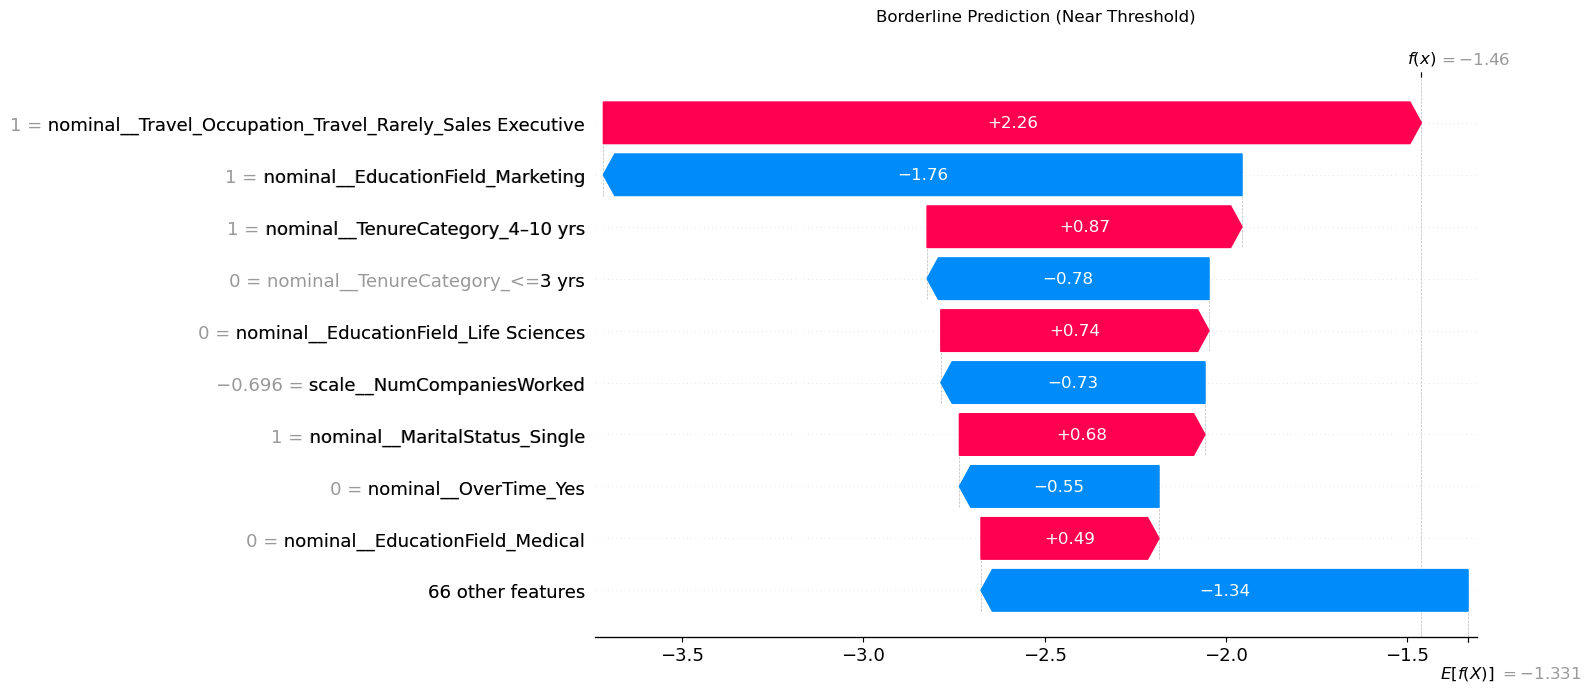

In [23]:
# Cell 3: Borderline Prediction (Near Threshold)

import shap
import matplotlib.pyplot as plt

# 1) Draw the SHAP waterfall
_ = shap.plots.waterfall(
    shap_values[i_borderline],  # precomputed SHAP values for median case
    max_display=10,
    show=False                  # suppress SHAP’s internal plt.show()
)

# 2) Grab SHAP’s figure & axes
fig = plt.gcf()
ax  = plt.gca()

# 3) Resize for long labels
fig.set_size_inches(14, 7)

# 4) Shift margins so nothing gets squished
fig.subplots_adjust(left=0.32, right=0.95, top=0.9, bottom=0.1)

# 5) Title with extra padding
ax.set_title("Borderline Prediction (Near Threshold)", pad=20)

# 6) Render
plt.show()


### Low-Risk Case (Most Confident Negative Prediction)

In contrast, this employee is confidently predicted to stay—what key factors drive this clear retention signal?

- Strong indicators of professional stability—including substantial **total working years**, a managerial role involving **frequent travel**, and recent **salary increases**—collectively outweigh any potential risks.
- A shorter tenure (**≤3 years**) marginally increases attrition risk, yet this minor negative influence is effectively neutralized by stronger positive signals.
- Mild negative factors like commute distance or lack of overtime remain present but have minimal overall impact.

This scenario underscores how robust indicators of career stability and progression can decisively secure a confident retention prediction, even in the presence of some conflicting signals.

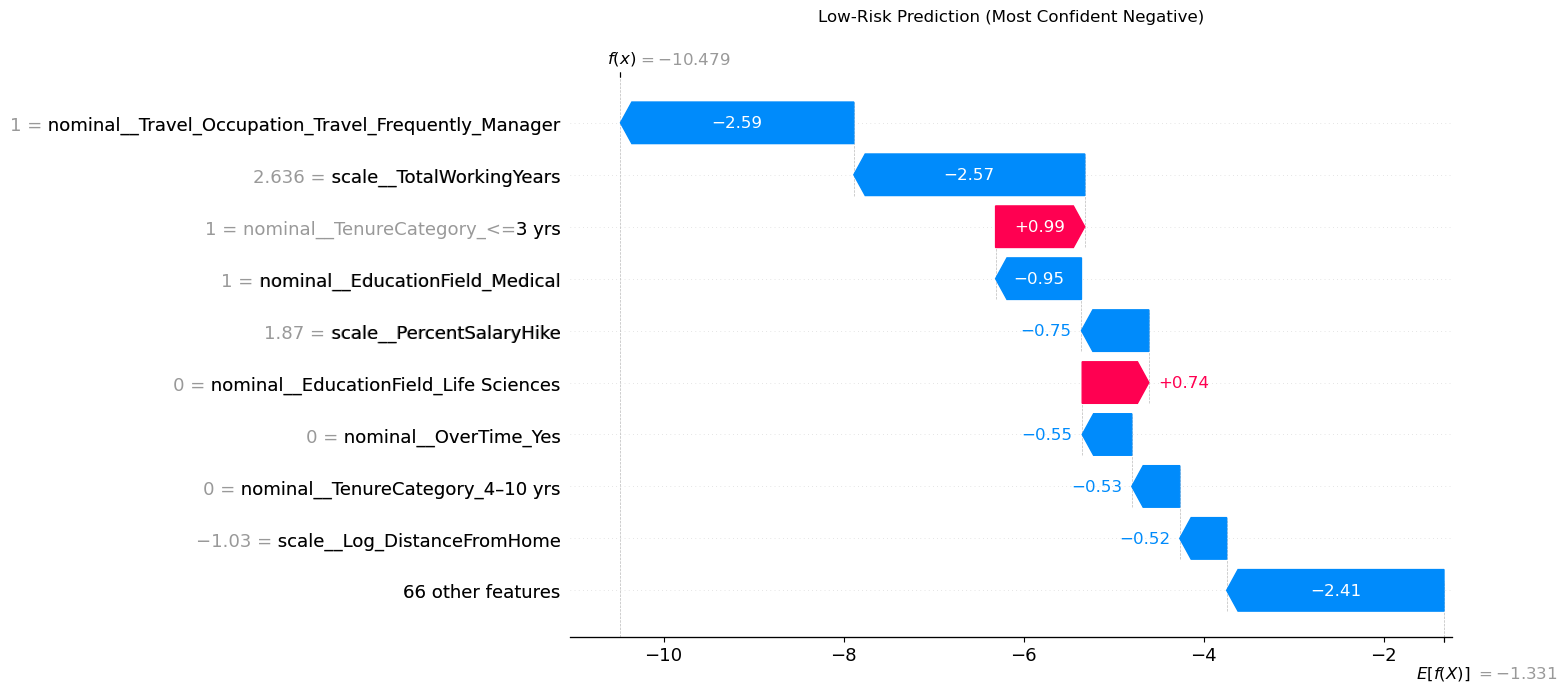

In [24]:
# Cell 4: Low-Risk Prediction (Most Confident Negative)

import shap
import matplotlib.pyplot as plt

# 1) Draw the SHAP waterfall
_ = shap.plots.waterfall(
    shap_values[i_low],  # precomputed SHAP values for safest case
    max_display=10,
    show=False           # suppress SHAP’s internal plt.show()
)

# 2) Grab SHAP’s figure & axes
fig = plt.gcf()
ax  = plt.gca()

# 3) Resize for long labels
fig.set_size_inches(14, 7)

# 4) Shift margins so nothing gets squished
fig.subplots_adjust(left=0.32, right=0.95, top=0.9, bottom=0.1)

# 5) Title with extra padding
ax.set_title("Low-Risk Prediction (Most Confident Negative)", pad=20)

# 6) Render
plt.show()


## 4. Coefficient perspective

---

Logistic-regression coefficients give a clean, first-order view of the model’s logic—each value estimates how a one-unit change in a feature shifts the log-odds of attrition when everything else is held constant. Plotting the 20 largest coefficients (absolute value) lets us X-ray the model before any non-linear interactions captured by SHAP.

| Sign | Interpretation |
|------|----------------|
| **Positive (red)** | Raises the log-odds of leaving (attrition risk) |
| **Negative (blue)** | Lowers the log-odds of leaving (retention signal) |

### Risk Amplifiers  
- **Frequent-travel roles** (`Travel_Occupation_Travel_Frequently_*`) dominate the upper tier—burnout and time away from home remain powerful push factors.  
- **Overtime** (`OverTime_JobLevel_Yes_*` and `OverTime_Yes`) shows up repeatedly, underscoring workload pressure.  
- **Short tenure** (`TenureCategory_<=3 yrs`) confirms the classic early-exit pattern.

### Retention Stabilizers  
- **Specialised or technical education** (`EducationField_Technical Degree`, `EducationField_Other`) hints at stronger organisational fit and career paths.  
- **Non-travel managerial / HR positions** (`Travel_Occupation_Non-Travel_*_Manager`, `*_Human Resources`) align with lower turnover, likely due to better work–life balance.  
- **Marketing & R&D specialists** post mild negative coefficients—role engagement can offset other stressors.

### Why This Matters Next to SHAP  
Coefficients nail down **direction and isolated strength**; SHAP (previous sections) adds **context and interaction effects**. The overlap—travel frequency, overtime, and early tenure—strengthens confidence that these are genuine, actionable signals.

**Bottom line:**  
Travel intensity and high workload sit at the heart of attrition risk, while specialised skills, managerial stability, and advanced education anchor employees. Coefficients and SHAP together give a consistent, multi-angle narrative to steer targeted retention strategies.

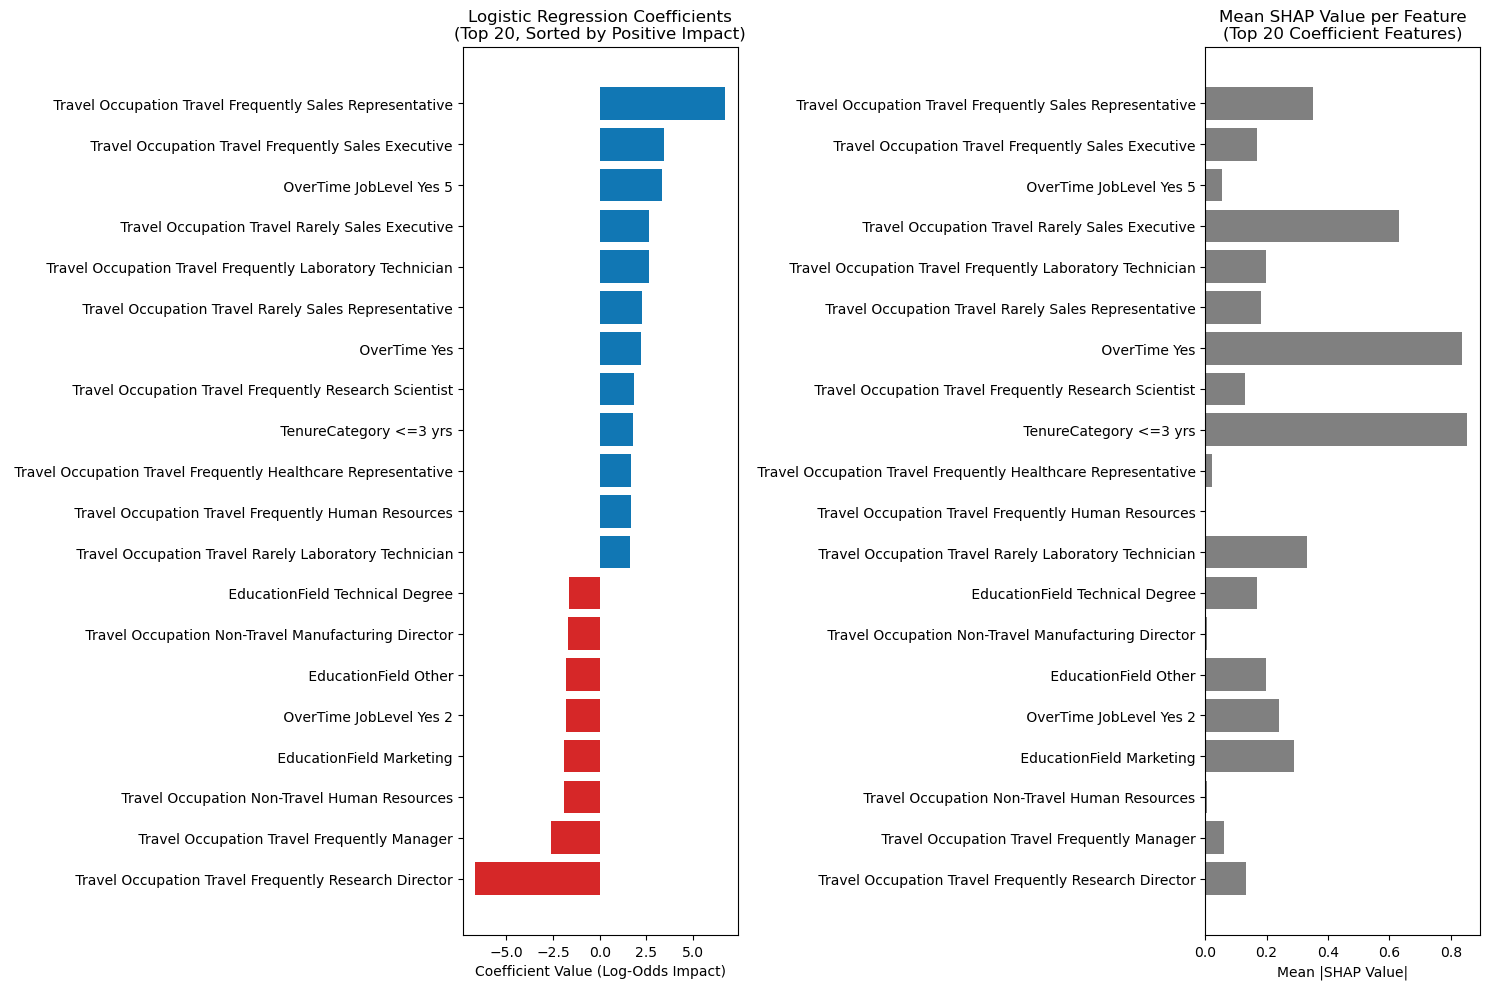

Model intercept: -3.566


In [14]:
# === Imports ===
import joblib
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import shap

# === Load Model, Data, and SHAP Values ===
classifier = joblib.load("../models/final_model.joblib")
X_transformed = pd.read_csv("../data/processed/x_test_transformed.csv")

with open("../models/x_test_columns.json", "r") as f:
    transformed_feature_names = json.load(f)

# === Clean Feature Names ===
def clean_name(name):
    return name.replace("nominal_", "").replace("scale_", "").replace("passthrough_", "").replace("_", " ")

# === SHAP Values ===
explainer = shap.Explainer(classifier, X_transformed, feature_names=transformed_feature_names)
shap_values = explainer(X_transformed)

# === Coefficients from Model ===
coefs = classifier.coef_[0]
intercept = classifier.intercept_[0]

coef_df = pd.DataFrame({
    "Feature": transformed_feature_names,
    "Coefficient": coefs
})
coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()

# === Grouping Logic ===
def extract_group(name):
    if "Travel" in name:
        return "Travel"
    elif "OverTime" in name:
        return "OverTime"
    elif "Department" in name:
        return "Department"
    elif "Satisfaction" in name or "Involvement" in name:
        return "Satisfaction"
    elif "JobRole" in name:
        return "Job Role"
    elif "Education" in name or "Field" in name:
        return "Education"
    elif "Income" in name or "Salary" in name or "Rate" in name:
        return "Compensation"
    elif "Years" in name or "Tenure" in name:
        return "Tenure"
    else:
        return "Other"

coef_df["Group"] = coef_df["Feature"].apply(extract_group)
coef_df["CleanFeature"] = coef_df["Feature"].apply(clean_name)

# === Top 20 Features by Coefficient Impact ===
top_coef_df = coef_df.sort_values(by="AbsCoefficient", ascending=False).head(20)
top_coef_df = top_coef_df.sort_values(by="Coefficient", ascending=False)

# === SHAP Mean Impact ===
mean_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "Feature": transformed_feature_names,
    "MeanSHAP": mean_shap
})
shap_df["Group"] = shap_df["Feature"].apply(extract_group)
shap_df["CleanFeature"] = shap_df["Feature"].apply(clean_name)

# === Merge and keep clean labels ===
merged_df = pd.merge(top_coef_df, shap_df[["Feature", "MeanSHAP", "Group", "CleanFeature"]], on="Feature", how="left")
merged_df = merged_df.sort_values(by="Coefficient", ascending=False)

merged_df["CleanFeature"] = merged_df["Feature"].apply(clean_name)

# === Plot side by side ===
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Use the shared CleanFeature for both plots
labels = merged_df["CleanFeature"]

# --- Coefficient Plot ---
axes[0].barh(
    labels,
    merged_df["Coefficient"],
    color=["#1177b4" if c > 0 else "#d62728" for c in merged_df["Coefficient"]]
)
axes[0].set_title("Logistic Regression Coefficients\n(Top 20, Sorted by Positive Impact)")
axes[0].set_xlabel("Coefficient Value (Log-Odds Impact)")
axes[0].invert_yaxis()

# --- SHAP Plot ---
axes[1].barh(
    labels,
    merged_df["MeanSHAP"],
    color="gray"
)
axes[1].set_title("Mean SHAP Value per Feature\n(Top 20 Coefficient Features)")
axes[1].set_xlabel("Mean |SHAP Value|")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Optional: print model intercept
print(f"Model intercept: {intercept:.3f}")


# **Conclusion and summary**

This notebook unpacks *why* our logistic-regression attrition model makes the predictions it does, combining coefficient analysis with SHAP for both **global** and **local** interpretability. Below is an up-to-date synthesis of the latest results.

---

### 1. Global Drivers (SHAP Violin + Bar)  
| Direction | Most Influential Features | Interpretation |
|-----------|---------------------------|----------------|
| ↑ Attrition Risk | `TenureCategory_<=3 yrs`, `OverTime_Yes`, `NumCompaniesWorked`, `Travel_Occupation_Travel Frequently` | Early-career volatility, workload pressure, job-hopping history, and heavy travel consistently push employees toward leaving. |
| ↓ Attrition Risk | `TotalWorkingYears`, `YearsWithCurrManager`, `SatisfactionMean`, `EducationField_Technical Degree`, `Travel_Occupation_Non-Travel_Manager/HR` | Professional stability, supportive management tenure, overall satisfaction, technical specialisation, and low-travel managerial roles anchor retention. |

> **Macro Insight:** Attrition risk is driven less by pay variables and more by career stage, workload, and mobility. Stability signals—long service, satisfied tenure, and low travel—are the strongest protectors.

---

### 2. Local Explanations (SHAP Waterfall)  
- **High-Risk Case**: A Sales Representative with *frequent travel* and heavy overtime shows an 8.98 log-odds spike toward attrition despite reasonable satisfaction—work–life strain dominates.  
- **Borderline Case**: A Sales Executive sits on the decision boundary; balanced pushes from marketing‐focused duties (+) versus medical education (−) highlight trade-offs HR might fine-tune (e.g., travel reduction).  
- **Low-Risk Case**: A Manager with **>10 years total experience**, healthy pay growth, and no overtime is confidently retained; minor negatives (long commute) are outweighed by strong career-progression signals.

> **Micro Insight:** SHAP pinpoints the exact mix of factors for targeted interventions—e.g., reduce travel or overtime in edge cases rather than blanket policies.

---

### 3. Threshold Sensitivity (0.5 vs 0.79)  

| Metric | 0.5 Threshold | 0.79 Threshold | Change |
|--------|---------------|---------------|--------|
| **False Positives** | 50 | **18** | −32 |
| **False Negatives** | 14 | **23** | +9 |
| **Flipped Predictions** | – | **41** employees | – |

- Raising the threshold refocuses alerts on *higher-certainty* attrition cases, cutting unnecessary outreach by 64 % (FP drop) at the cost of 9 missed true attritions.  
- SHAP on flipped cases clarifies the trade-offs, enabling policy makers to set thresholds aligned with business costs (false positives vs. false negatives).

---

### 4. Coefficients vs SHAP: Consistent Narrative  
Both methods highlight **travel frequency, overtime, and short tenure** as dominant risk cues, while **technical education and managerial stability** emerge as protective. Alignment between linear coefficients and SHAP boosts trust in the model’s logic.

---

### 5. Practical Implications  
1. **Targeted Retention** Prioritise employees with short tenure *and* high travel/overtime for early interventions.  
2. **Work–Life Balance** Reducing sustained overtime delivers outsized retention gains.  
3. **Career Pathing** Supporting technical up-skilling and clear managerial tracks strengthens long-term loyalty.  
4. **Threshold Governance** Revisit threshold periodically; cost of false negatives vs. false positives may shift with business priorities.

---

### Conclusion  
By blending model predictions with transparent explainability techniques, we move from a black-box classifier to an actionable, auditable decision tool. Stakeholders can *see* the drivers, *weigh* the trade-offs, and *act* with confidence.
